Setup

In [45]:
# Packages 

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns 

In [46]:
# Generate the datasets with different levels of overlaps following Dal Pozzolo section III.B
def generate_datasets(n_samples = 10000, overlaps = [3,15]):
    datasets  = {}
    for overlap in overlaps:
        X, y = make_classification(
            n_samples = n_samples, 
            n_features = 2,
            n_redundant = 0, 
            n_clusters_per_class = 1, 
            weights = [0.99, 0.01],
            class_sep = overlap, 
            random_state = 42
        )
        datasets[f'overlap_{overlap}'] = (X,y)
    return datasets

In [47]:
# Undersample the majority class with sampling rate $\beta$
def undersample(X,y,beta):
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]
    
    n_neg_samples = int(len(pos_idx)/beta) if beta>0 else len(neg_idx)
    selected_neg_idx = np.random.choice(neg_idx, size = n_neg_samples, replace = False)
    
    selected_idx = np.concatenate([pos_idx, selected_neg_idx])
    return X[selected_idx], y[selected_idx]

In [48]:

# Correct the probabilities p_s to p. (I made an error in the write up claiming that the numerator was simply p_s, when it shoudl be \beta*p_s like it is here)
def correct_probabilities(ps, beta):
    corrected = (beta*ps)/(beta*ps-ps+1)
    
    # check for out of bounds values, this might push values to be too great 
    if np.any((corrected<0)|(corrected>1)):
        print(f"Warning: {np.sum((corrected<0)|(corrected>1))} values outside [0,1]")
        print(f"Min Value: {np.min(corrected)} Max Value: {np.max(corrected)}")
        print(f"Beta: {beta}")
        
    return np.clip(corrected, 0,1)
    



In [49]:
'''
def correct_probabilities(ps, beta):
    """Apply probability correction formula with detailed diagnostics"""
    # Check input probabilities
    if np.any((ps < 0) | (ps > 1)):
        print("Warning: Input probabilities outside [0,1]")
        print(f"Input min: {np.min(ps)}, max: {np.max(ps)}")
    
    corrected = (beta * ps) / (beta * ps - ps + 1)
    
    # Check corrected probabilities
    if np.any((corrected < 0) | (corrected > 1)):
        print("Warning: Corrected probabilities outside [0,1]")
        print(f"Output min: {np.min(corrected)}, max: {np.max(corrected)}")
        print(f"Beta: {beta}")
        
        # Show some example problematic cases
        mask = (corrected < 0) | (corrected > 1)
        print("\nProblematic cases:")
        print("Original prob -> Corrected prob")
        for orig, corr in zip(ps[mask], corrected[mask])[:5]:
            print(f"{orig:.4f} -> {corr:.4f}")
    
    return np.clip(corrected, 0, 1)
    '''

'\ndef correct_probabilities(ps, beta):\n    """Apply probability correction formula with detailed diagnostics"""\n    # Check input probabilities\n    if np.any((ps < 0) | (ps > 1)):\n        print("Warning: Input probabilities outside [0,1]")\n        print(f"Input min: {np.min(ps)}, max: {np.max(ps)}")\n    \n    corrected = (beta * ps) / (beta * ps - ps + 1)\n    \n    # Check corrected probabilities\n    if np.any((corrected < 0) | (corrected > 1)):\n        print("Warning: Corrected probabilities outside [0,1]")\n        print(f"Output min: {np.min(corrected)}, max: {np.max(corrected)}")\n        print(f"Beta: {beta}")\n        \n        # Show some example problematic cases\n        mask = (corrected < 0) | (corrected > 1)\n        print("\nProblematic cases:")\n        print("Original prob -> Corrected prob")\n        for orig, corr in zip(ps[mask], corrected[mask])[:5]:\n            print(f"{orig:.4f} -> {corr:.4f}")\n    \n    return np.clip(corrected, 0, 1)\n    '

Evaluate

In [50]:
# Evauluate Model with metrics from paper (AUC, Brier Score, and Precision)
def evaluate_model(clf, X_train, X_test, y_train, y_test, beta):
    
    # train on the undersampled data
    X_train_under, y_train_under = undersample(X_train, y_train, beta)
    
    # fit classifier to the data
    clf.fit(X_train_under, y_train_under)
    
    # get probabilities
    ps = clf.predict_proba(X_test)[:,1]
    p_corrected = correct_probabilities(ps,beta)
    
    # calculate calibration curves
    prob_true, prob_pred = calibration_curve(y_test, ps, n_bins = 10)
    prob_true_corr, prob_pred_corr = calibration_curve(y_test, p_corrected, n_bins = 10)
    
    return{
        'raw_probs':ps, 
        'corrected_probs':p_corrected,
        'calibration':{
            'true_raw':prob_true,
            'pred_raw': prob_pred,
            'true_corr':prob_true_corr, 
            'pred_corr': prob_pred_corr   
        },
        'metrics':{
            'auc_raw':roc_auc_score(y_test, ps),
            'auc_corrected':roc_auc_score(y_test, p_corrected),
            'brier_raw': brier_score_loss(y_test,ps),
            'brier_corrected': brier_score_loss(y_test,p_corrected),
            'ap_raw':average_precision_score(y_test,ps),
            'ap_corrected':average_precision_score(y_test, p_corrected)
        }
    }

Plot

In [51]:
# Create Matching visualizations and extending paper figures from Dal Pozzolo  
def plot_results(results, overlap):
    fig, axes = plt.subplots(2,2,figsize=(15,15))
    
    # plot 1 - probability calibration curves (figure 4 in paper)
    ax = axes[0,0]
    for name, res in results.items():
        ax.plot(res['calibration']['pred_raw'],
                res['calibration']['true_raw'],
                    label=f'{name} (Raw)', linestyle = '--')
        ax.plot(res['calibration']['pred_corr'],
                res['calibration']['true_corr'],
                    label=f'{name} (Corrected)') 
    ax.plot([0,1],[0,1],'k:', label='Perfectly Calibrated')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('True Probability')
    ax.set_title(f'Probability Calibration (Overlap={overlap})')
    ax.legend()
    
    # plot 2 - Probability distributions
    ax = axes[0,1]
    for name, res in results.items():
        sns.kdeplot(res['raw_probs'], label=f'{name} (Raw)', ax=ax)
        sns.kdeplot(res['corrected_probs'], label=f'{name} (Corrected)', ax=ax)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Density')
    ax.set_title('Probability Distribution')
    ax.legend()
    
    # plot 3 - Metrics comparisons
    ax = axes[1,0]
    metrics_df = pd.DataFrame([
        {
            'Model': name, 
            'AUC': res['metrics']['auc_corrected'],
            'Brier':res['metrics']['brier_corrected'],
            'AP':res['metrics']['ap_corrected']
        }
        for name, res in results.items()
    ])
    metrics_df.plot(x = 'Model', kind='bar', ax=ax)
    ax.set_title('Model Performance Comparison')
    ax.set_label('Score')
    plt.xticks(rotation=45)
    
    # Plot 4: Correction Impact
    ax = axes[1,1]
    improvement_df = pd.DataFrame([
        {
            'Model':name,
            'Brier Score Improvement': res['metrics']['brier_raw']-res['metrics']['brier_corrected'],
            'AUC Difference': res['metrics']['auc_raw']-res['metrics']['auc_corrected']
        }
        for name, res in results.items()
    ])
    improvement_df.plot(x='Model', kind='bar', ax = ax)
    ax.set_title('Impact of Probability Correction')
    ax.set_ylabel('Improvement')
    plt.xticks(rotation = 45)

Now Actually run the things you just spent an eternity creating     

Original class ratio: 0.013
Beta value: 0.014

Evaluating Logistic Regressions on overlap_3...
AUC (Raw/Corrected): 0.856/0.856
Brier Score (Raw/Corrected): 0.004/0.008
Average Precision (Raw/Corrected): 0.751/0.751

Evaluating Random Forest on overlap_3...
Min Value: 0.0 Max Value: 1.0000000000000009
Beta: 0.013611352447147408
AUC (Raw/Corrected): 0.874/0.874
Brier Score (Raw/Corrected): 0.005/0.006
Average Precision (Raw/Corrected): 0.752/0.752

Evaluating SVM on overlap_3...
AUC (Raw/Corrected): 0.848/0.848
Brier Score (Raw/Corrected): 0.004/0.007
Average Precision (Raw/Corrected): 0.753/0.753

Evaluating Neural Network on overlap_3...
AUC (Raw/Corrected): 0.895/0.895
Brier Score (Raw/Corrected): 0.004/0.010
Average Precision (Raw/Corrected): 0.755/0.755

Evaluating Gradient Boosting on overlap_3...
AUC (Raw/Corrected): 0.834/0.834
Brier Score (Raw/Corrected): 0.008/0.007
Average Precision (Raw/Corrected): 0.557/0.557
Original class ratio: 0.013
Beta value: 0.014

Evaluating Logisti

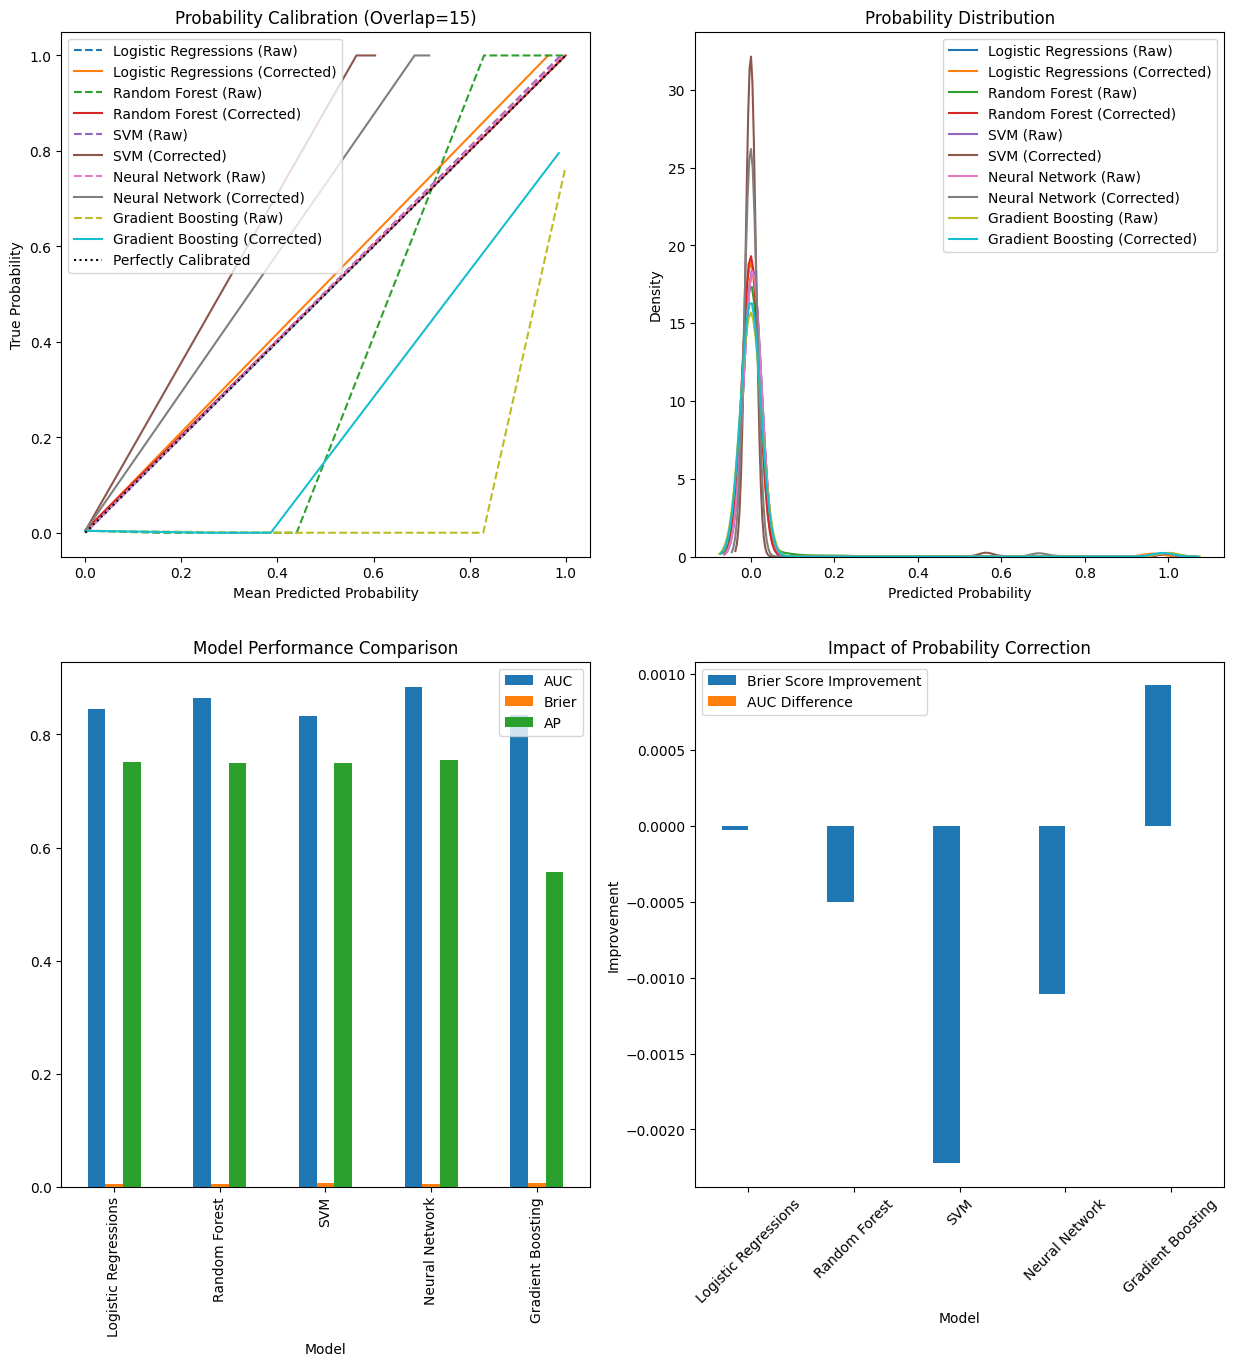

In [54]:
def main():
    # Generate the datasets 
    datasets = generate_datasets(overlaps = [3,15])
    
    # Define Classifiers we want to test out
    classifiers = {
        'Logistic Regressions': LogisticRegression(), 
        'Random Forest': RandomForestClassifier(n_estimators = 100),
        'SVM': SVC(probability=True), 
        'Neural Network': MLPClassifier(hidden_layer_sizes=(10,)),
        'Gradient Boosting': GradientBoostingClassifier()
    }
    
    #Evaluate each classifier from ^ on each of the datasets!
    all_results = {}
    for overlap, (X,y) in datasets.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
        beta = np.sum(y_train == 1) / np.sum(y_train == 0)
        print(f"Original class ratio: {np.sum(y_train == 1) / len(y_train):.3f}")
        print(f"Beta value: {beta:.3f}")

        results = {}
        for name, clf in classifiers.items():
            print(f"\nEvaluating {name} on {overlap}...")
            results[name] = evaluate_model(clf, X_train, X_test, y_train, y_test, beta)
            print(f"AUC (Raw/Corrected): {results[name]['metrics']['auc_raw']:.3f}/{results[name]['metrics']['auc_corrected']:.3f}")
            print(f"Brier Score (Raw/Corrected): {results[name]['metrics']['brier_raw']:.3f}/{results[name]['metrics']['brier_corrected']:.3f}")
            print(f"Average Precision (Raw/Corrected): {results[name]['metrics']['ap_raw']:.3f}/{results[name]['metrics']['ap_corrected']:.3f}")
        
    # plot the results for this level of overlap. 
    fig  = plot_results(results, overlap.split('_')[1])
    plt.show()
    
    all_results[overlap] = results
    return all_results

if __name__ == "__main__": 
    results = main()